# Feature-Based Explanations using Saliency Library

## Overview

This lab shows how to train a classification model on image data and deploy it to Vertex AI to serve predictions with explanations (feature attributions). In this lab you will:
* Explore the dataset
* Build and train a custom image classification model with Vertex AI
* Deploy the model to an endpoint
* Serve predictions with explanations
* Visualize feature attributions from Integrated Gradients

## Setup

### Import libraries

Import the libraries for this tutorial.

In [1]:
import os
import warnings

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
warnings.filterwarnings("ignore")

In [2]:
import base64
import os
import random
from datetime import datetime
from io import BytesIO

import matplotlib.image as mpimg
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
from google.cloud import aiplatform
from matplotlib import pyplot as plt

2024-03-14 18:24:36.829334: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-14 18:24:36.829415: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-14 18:24:36.831071: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
PROJECT = !(gcloud config get-value core/project)
PROJECT = PROJECT[0]
BUCKET = PROJECT  # defaults to PROJECT
REGION = "us-central1"  # Replace with your REGION

# TIMESTAMP = datetime.now().strftime("%Y%m%d%H%M%S")
GCS_PATTERN = "gs://flowers-public/tfrecords-jpeg-192x192-2/*.tfrec"
DATA_PATH = f"gs://{BUCKET}/flowers/data"
# OUTDIR = f"gs://{BUCKET}/flowers/model_{TIMESTAMP}"

# os.environ["BUCKET"] = BUCKET
# os.environ["REGION"] = REGION
# os.environ["DATA_PATH"] = DATA_PATH
# os.environ["OUTDIR"] = OUTDIR
# os.environ["TIMESTAMP"] = TIMESTAMP
# print(f"Project: {PROJECT}")

Run the following cell to create your Cloud Storage bucket if it does not already exist.

In [4]:
# %%bash
# exists=$(gsutil ls -d | grep -w gs://${BUCKET}/)

# if [ -n "$exists" ]; then
#    echo -e "Bucket gs://${BUCKET} already exists."

# else
#    echo "Creating a new GCS bucket."
#    gsutil mb -l ${REGION} gs://${BUCKET}
#    echo -e "\nHere are your current buckets:"
#    gsutil ls
# fi

## Explore the Dataset
The dataset used for this tutorial is the [flowers dataset](https://www.tensorflow.org/datasets/catalog/tf_flowers) from [TensorFlow Datasets](https://www.tensorflow.org/datasets/catalog/overview). This section shows how to shuffle, split, and copy the files to your GCS bucket. 

### Load, split, and copy the dataset to your GCS bucket

In [5]:
TRAINING_DATA_PATH = DATA_PATH + "/training"
EVAL_DATA_PATH = DATA_PATH + "/validation"
VALIDATION_SPLIT = 0.2

# Split data files between training and validation
filenames = tf.io.gfile.glob(GCS_PATTERN)
random.shuffle(filenames)
split = int(len(filenames) * VALIDATION_SPLIT)
training_filenames = filenames[split:]
validation_filenames = filenames[:split]

# Copy training files to GCS
for file in training_filenames:
    !gsutil -m cp $file $TRAINING_DATA_PATH/

# Copy eval files to GCS
for file in validation_filenames:
    !gsutil -m cp $file $EVAL_DATA_PATH/

Copying gs://flowers-public/tfrecords-jpeg-192x192-2/flowers08-230.tfrec...
/ [1/1 files][  5.9 MiB/  5.9 MiB] 100% Done                                    
Operation completed over 1 objects/5.9 MiB.                                      
Copying gs://flowers-public/tfrecords-jpeg-192x192-2/flowers04-230.tfrec...
/ [1/1 files][  5.8 MiB/  5.8 MiB] 100% Done                                    
Operation completed over 1 objects/5.8 MiB.                                      
Copying gs://flowers-public/tfrecords-jpeg-192x192-2/flowers07-230.tfrec...
/ [1/1 files][  5.8 MiB/  5.8 MiB] 100% Done                                    
Operation completed over 1 objects/5.8 MiB.                                      
Copying gs://flowers-public/tfrecords-jpeg-192x192-2/flowers09-230.tfrec...
/ [1/1 files][  6.0 MiB/  6.0 MiB] 100% Done                                    
Operation completed over 1 objects/6.0 MiB.                                      
Copying gs://flowers-public/tfrecords-jpeg-1

Run the following commands. You should see a number of .tfrec files in your GCS bucket at both gs://{BUCKET}/flowers/data/training and gs://{BUCKET}/flowers/data/validation

In [6]:
!gsutil ls -l $TRAINING_DATA_PATH

   6250983  2024-03-14T18:25:00Z  gs://takumiohym-sandbox/flowers/data/training/flowers00-230.tfrec
   6231074  2024-03-14T18:25:05Z  gs://takumiohym-sandbox/flowers/data/training/flowers01-230.tfrec
   5952336  2024-03-14T18:25:14Z  gs://takumiohym-sandbox/flowers/data/training/flowers02-230.tfrec
   6254378  2024-03-14T18:25:03Z  gs://takumiohym-sandbox/flowers/data/training/flowers03-230.tfrec
   6056727  2024-03-14T18:24:49Z  gs://takumiohym-sandbox/flowers/data/training/flowers04-230.tfrec
   6100076  2024-03-14T18:25:10Z  gs://takumiohym-sandbox/flowers/data/training/flowers05-230.tfrec
   5968916  2024-03-14T18:25:07Z  gs://takumiohym-sandbox/flowers/data/training/flowers06-230.tfrec
   6088244  2024-03-14T18:24:51Z  gs://takumiohym-sandbox/flowers/data/training/flowers07-230.tfrec
   6162742  2024-03-14T18:24:47Z  gs://takumiohym-sandbox/flowers/data/training/flowers08-230.tfrec
   6346261  2024-03-14T18:24:53Z  gs://takumiohym-sandbox/flowers/data/training/flowers09-230.tfrec


In [7]:
!gsutil ls -l $EVAL_DATA_PATH

   6250983  2024-03-14T15:40:09Z  gs://takumiohym-sandbox/flowers/data/validation/flowers00-230.tfrec
   6231074  2023-08-17T16:07:25Z  gs://takumiohym-sandbox/flowers/data/validation/flowers01-230.tfrec
   5952336  2023-11-06T12:07:39Z  gs://takumiohym-sandbox/flowers/data/validation/flowers02-230.tfrec
   6254378  2024-03-01T08:16:26Z  gs://takumiohym-sandbox/flowers/data/validation/flowers03-230.tfrec
   6056727  2024-03-14T15:40:07Z  gs://takumiohym-sandbox/flowers/data/validation/flowers04-230.tfrec
   6100076  2023-08-18T11:10:31Z  gs://takumiohym-sandbox/flowers/data/validation/flowers05-230.tfrec
   5968916  2023-08-18T11:55:39Z  gs://takumiohym-sandbox/flowers/data/validation/flowers06-230.tfrec
   6088244  2023-08-18T11:55:37Z  gs://takumiohym-sandbox/flowers/data/validation/flowers07-230.tfrec
   6162742  2024-03-14T15:40:05Z  gs://takumiohym-sandbox/flowers/data/validation/flowers08-230.tfrec
   6346261  2023-08-17T15:51:39Z  gs://takumiohym-sandbox/flowers/data/validation/

### Create ingest functions and visualize some of the examples
Define and execute helper functions to plot the images and corresponding labels.

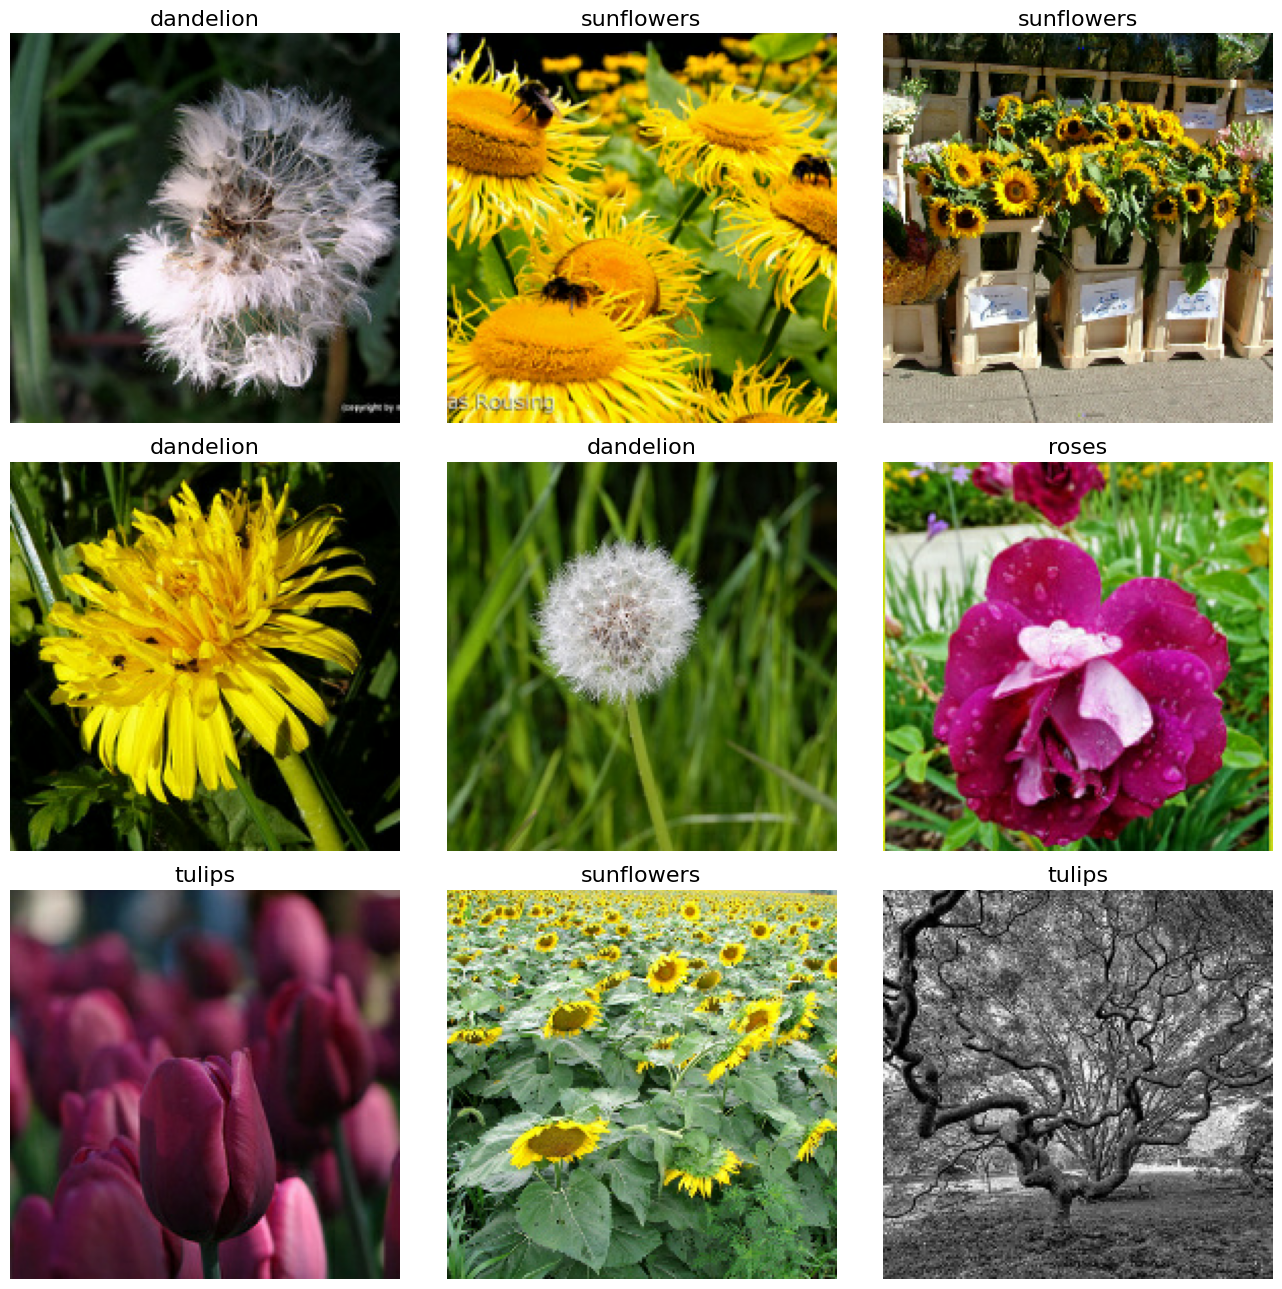

In [8]:
IMAGE_SIZE = [192, 192]
BATCH_SIZE = 32

# Do not change, maps to the labels in the data
CLASSES = [
    "daisy",
    "dandelion",
    "roses",
    "sunflowers",
    "tulips",
]


def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature(
            [], tf.string
        ),  # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means scalar
        "one_hot_class": tf.io.VarLenFeature(tf.float32),
    }
    example = tf.io.parse_single_example(example, features)
    image = tf.image.decode_jpeg(example["image"], channels=3)
    image = (
        tf.cast(image, tf.float32) / 255.0
    )  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    one_hot_class = tf.sparse.to_dense(example["one_hot_class"])
    one_hot_class = tf.reshape(one_hot_class, [5])
    return image, one_hot_class


# Load tfrecords into tf.data.Dataset
def load_dataset(gcs_pattern):
    filenames = tf.io.gfile.glob(gcs_pattern + "/*")
    ds = tf.data.TFRecordDataset(filenames).map(read_tfrecord)
    return ds


# Converts N examples in dataset to numpy arrays
def dataset_to_numpy(dataset, N):
    numpy_images = []
    numpy_labels = []

    for images, labels in dataset.take(N):
        numpy_images.append(images.numpy())
        numpy_labels.append(labels.numpy())

    return numpy_images, numpy_labels


def display_one_image(image, title, subplot):
    plt.subplot(subplot)
    plt.axis("off")
    plt.imshow(image)
    plt.title(title, fontsize=16)
    return subplot + 1


def display_9_images_from_dataset(dataset):
    subplot = 331
    plt.figure(figsize=(13, 13))
    images, labels = dataset_to_numpy(dataset, 9)
    for i, image in enumerate(images):
        title = CLASSES[np.argmax(labels[i], axis=-1)]
        subplot = display_one_image(image, title, subplot)
        if i >= 8:
            break

    plt.tight_layout()
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()


# Display 9 examples from the dataset
ds = load_dataset(gcs_pattern=TRAINING_DATA_PATH)
display_9_images_from_dataset(ds)

## Build training pipeline
In this section you will build an application with keras to train an image classification model on Vertex AI Custom Training. 

### Create training application in train.py

This code contains the training logic. Here you build an application to ingest data from GCS and train an image classification model using [mobileNet](https://tfhub.dev/google/imagenet/mobilenet_v2_100_192/feature_vector/5) as a feature extractor, then sending it's output feature vector through a tf.keras.dense layer with 5 units and softmax activation (because there are 5 possible labels). Also, use the `fire` library which enables arguments to `train_and_evaluate` to be passed via the command line. 

In [13]:
import datetime
import os

import tensorflow as tf
import tensorflow_hub as hub

IMAGE_SIZE = [192, 192]


def read_tfrecord(example):

    features = {
        "image": tf.io.FixedLenFeature(
            [], tf.string
        ),  # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means scalar
        "one_hot_class": tf.io.VarLenFeature(tf.float32),
    }
    example = tf.io.parse_single_example(example, features)
    image = tf.image.decode_jpeg(example["image"], channels=3)
    image = (
        tf.cast(image, tf.float32) / 255.0
    )  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    one_hot_class = tf.sparse.to_dense(example["one_hot_class"])
    one_hot_class = tf.reshape(one_hot_class, [5])
    return image, one_hot_class


def load_dataset(gcs_pattern, batch_size=32, training=True):
    filenames = tf.io.gfile.glob(gcs_pattern)
    ds = tf.data.TFRecordDataset(filenames).map(read_tfrecord).batch(batch_size)
    if training:
        return ds.repeat()
    else:
        return ds


def build_model():
    # MobileNet model for feature extraction
    mobilenet_v2 = (
        "https://tfhub.dev/google/imagenet/"
        "mobilenet_v2_100_192/feature_vector/5"
    )
    feature_extractor_layer = hub.KerasLayer(
        mobilenet_v2, input_shape=[*IMAGE_SIZE, 3], trainable=False
    )

    # Instantiate model
    model = tf.keras.Sequential(
        [
            feature_extractor_layer,
            tf.keras.layers.Dense(5, activation="softmax"),
        ]
    )

    model.compile(
        optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
    )

    return model


def train_and_evaluate(
    train_data_path,
    eval_data_path,
    output_dir,
    batch_size,
    num_epochs,
    train_examples,
):

    model = build_model()
    train_ds = load_dataset(gcs_pattern=train_data_path, batch_size=batch_size)
    eval_ds = load_dataset(gcs_pattern=eval_data_path, training=False)
    num_batches = batch_size * num_epochs
    steps_per_epoch = train_examples // num_batches

    history = model.fit(
        train_ds,
        validation_data=eval_ds,
        epochs=num_epochs,
        steps_per_epoch=steps_per_epoch,
    )

    model.save(output_dir)

    print(f"Exported trained model to {output_dir}")
    return model

### Test training application locally 
It's always a good idea to test out a training application locally (with only a few training steps) to make sure the code runs as expected.

In [14]:
model = train_and_evaluate(
    train_data_path=f"gs://{BUCKET}/flowers/data/training/*.tfrec",
    eval_data_path=f"gs://{BUCKET}/flowers/data/validation/*.tfrec",
    output_dir="model",
    batch_size=32,
    num_epochs=15,
    train_examples=15000,
)

Epoch 1/15
31/31 [==============================] - 64s 2s/step - loss: 1.1528 - accuracy: 0.5534 - val_loss: 0.6691 - val_accuracy: 0.7779
Epoch 2/15
31/31 [==============================] - 56s 2s/step - loss: 0.5770 - accuracy: 0.8034 - val_loss: 0.4769 - val_accuracy: 0.8398
Epoch 3/15
31/31 [==============================] - 57s 2s/step - loss: 0.4557 - accuracy: 0.8468 - val_loss: 0.3897 - val_accuracy: 0.8728
Epoch 4/15
31/31 [==============================] - 56s 2s/step - loss: 0.4125 - accuracy: 0.8564 - val_loss: 0.3466 - val_accuracy: 0.8875
Epoch 5/15
31/31 [==============================] - 58s 2s/step - loss: 0.3492 - accuracy: 0.8921 - val_loss: 0.3146 - val_accuracy: 0.8959
Epoch 6/15
31/31 [==============================] - 57s 2s/step - loss: 0.3080 - accuracy: 0.8982 - val_loss: 0.2826 - val_accuracy: 0.9090
Epoch 7/15
31/31 [==============================] - 58s 2s/step - loss: 0.2995 - accuracy: 0.9022 - val_loss: 0.2785 - val_accuracy: 0.9068
Epoch 8/15
31/31 [==

INFO:tensorflow:Assets written to: model/assets


Exported trained model to model


**NOTE** Model training will take 5 minutes or so. You have to wait for training to finish before moving forward.

In [15]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_2 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense_2 (Dense)             (None, 5)                 6405      
                                                                 
Total params: 2264389 (8.64 MB)
Trainable params: 6405 (25.02 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


## Explanation with Saliency library


In [16]:
import saliency.core as saliency

In [45]:
class_idx_str = "class_idx_str"


def call_model_function(images, call_model_args=None, expected_keys=None):
    target_class_idx = call_model_args[class_idx_str]
    images = tf.convert_to_tensor(images)
    with tf.GradientTape() as tape:
        if expected_keys == [saliency.base.INPUT_OUTPUT_GRADIENTS]:
            tape.watch(images)
            output_layer = model(images)
            output_layer = output_layer[:, target_class_idx]
            gradients = np.array(tape.gradient(output_layer, images))
            return {saliency.base.INPUT_OUTPUT_GRADIENTS: gradients}
        else:
            conv_layer, output_layer = model(images)
            gradients = np.array(tape.gradient(output_layer, conv_layer))
            return {
                saliency.base.CONVOLUTION_LAYER_VALUES: conv_layer,
                saliency.base.CONVOLUTION_OUTPUT_GRADIENTS: gradients,
            }

In [51]:
eval_ds = load_dataset(
    gcs_pattern=f"gs://{BUCKET}/flowers/data/validation/*.tfrec",
    batch_size=1,
    training=False,
)

In [52]:
for d in eval_ds.shuffle(1000).take(1):
    image = d[0][0]
    result = model(tf.expand_dims(image, 0), 0)

In [53]:
prediction_class = tf.argmax(result, axis=-1).numpy()[0]
call_model_args = {class_idx_str: prediction_class}

In [54]:
def ShowImage(im, title="", ax=None):
    if ax is None:
        P.figure()
    P.axis("off")
    P.imshow(im)
    P.title(title)


def ShowGrayscaleImage(im, title="", ax=None):
    if ax is None:
        P.figure()
    P.axis("off")

    P.imshow(im, cmap=P.cm.gray, vmin=0, vmax=1)
    P.title(title)


def ShowHeatMap(im, title, ax=None):
    if ax is None:
        P.figure()
    P.axis("off")
    P.imshow(im, cmap="inferno")
    P.title(title)

Let's check the prediction result.

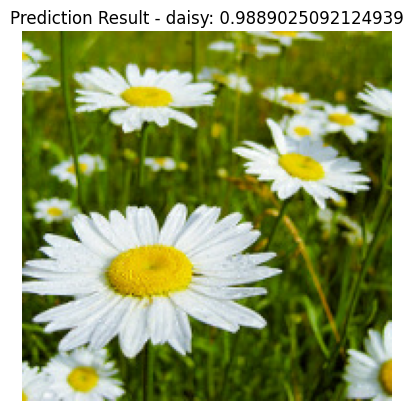

In [55]:
ShowImage(
    image,
    title=f"Prediction Result - {CLASSES[prediction_class]}: {result[0][prediction_class].numpy()}",
)

### Integrated Gradients

In [56]:
integrated_gradients = saliency.IntegratedGradients()

# Baseline is a black image.
baseline = np.zeros(image.shape)
# baseline = np.ones(image.shape) # White image

# Compute the vanilla mask and the smoothed mask.
vanilla_integrated_gradients_mask_3d = integrated_gradients.GetMask(
    image,
    call_model_function,
    call_model_args,
    x_steps=25,
    x_baseline=baseline,
    batch_size=20,
)
# Smoothed mask for integrated gradients will take a while since we are doing nsamples * nsamples computations.
smoothgrad_integrated_gradients_mask_3d = integrated_gradients.GetSmoothedMask(
    image,
    call_model_function,
    call_model_args,
    x_steps=25,
    x_baseline=baseline,
    batch_size=20,
)

# Call the visualization methods to convert the 3D tensors to 2D grayscale.
vanilla_mask_grayscale = saliency.VisualizeImageGrayscale(
    vanilla_integrated_gradients_mask_3d
)
smoothgrad_mask_grayscale = saliency.VisualizeImageGrayscale(
    smoothgrad_integrated_gradients_mask_3d
)

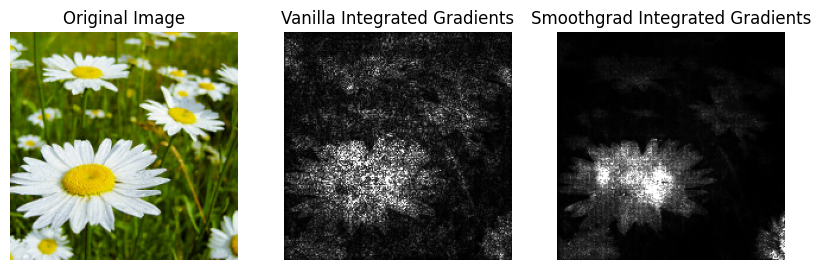

In [57]:
from matplotlib import pylab as P

# Set up matplot lib figures.
ROWS = 1
COLS = 3
UPSCALE_FACTOR = 10
P.figure(figsize=(ROWS * UPSCALE_FACTOR, COLS * UPSCALE_FACTOR))

# Render the saliency masks.
ShowImage(image, title="Original Image", ax=P.subplot(ROWS, COLS, 1))
ShowGrayscaleImage(
    vanilla_mask_grayscale,
    title="Vanilla Integrated Gradients",
    ax=P.subplot(ROWS, COLS, 2),
)
ShowGrayscaleImage(
    smoothgrad_mask_grayscale,
    title="Smoothgrad Integrated Gradients",
    ax=P.subplot(ROWS, COLS, 3),
)

### XRAI

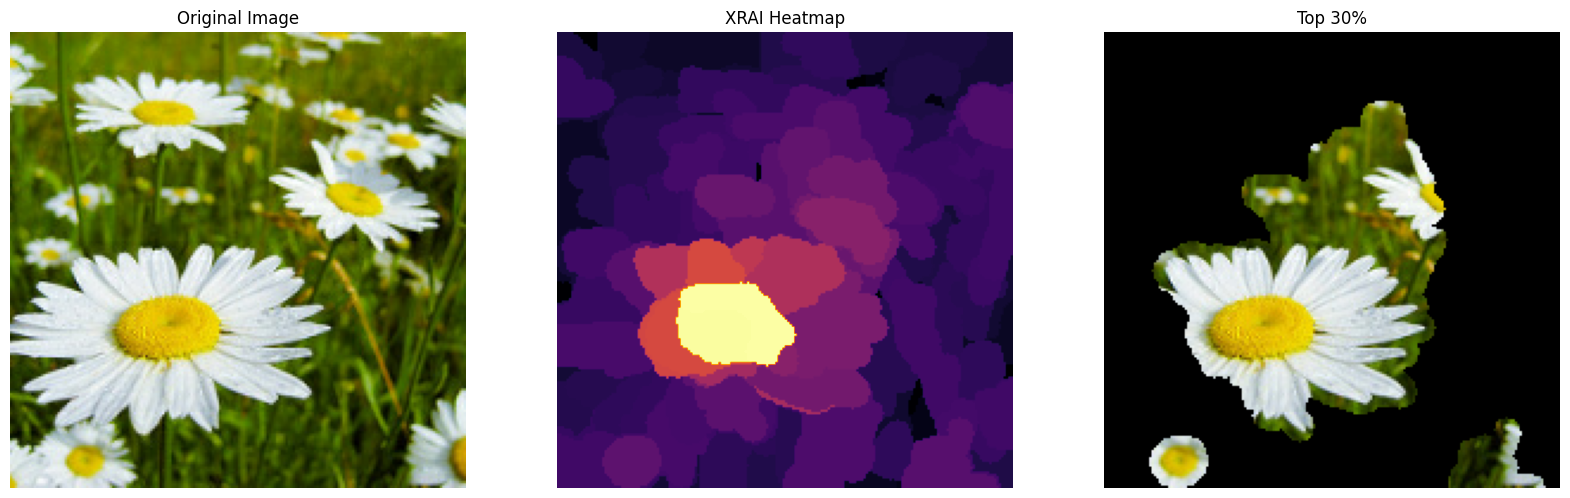

In [58]:
# Construct the saliency object. This alone doesn't do anthing.
xrai_object = saliency.XRAI()

# Compute XRAI attributions with default parameters
xrai_attributions = xrai_object.GetMask(
    image.numpy(), call_model_function, call_model_args, batch_size=20
)

# Set up matplot lib figures.
ROWS = 1
COLS = 3
UPSCALE_FACTOR = 20
P.figure(figsize=(ROWS * UPSCALE_FACTOR, COLS * UPSCALE_FACTOR))

# Show original image
ShowImage(image, title="Original Image", ax=P.subplot(ROWS, COLS, 1))

# Show XRAI heatmap attributions
ShowHeatMap(
    xrai_attributions, title="XRAI Heatmap", ax=P.subplot(ROWS, COLS, 2)
)

# Show most salient 30% of the image
mask = xrai_attributions >= np.percentile(xrai_attributions, 70)
im_mask = np.array(image)
im_mask[~mask] = 0
ShowImage(im_mask, title="Top 30%", ax=P.subplot(ROWS, COLS, 3))

## What's next?

To learn more about AI Explanations, check out the resources here.

* [Vertex AI Explanations documentation](https://cloud.google.com/vertex-ai/docs/explainable-ai)
* [Integrated gradients paper](https://arxiv.org/abs/1703.01365)
* [XRAI paper](https://arxiv.org/abs/1906.02825)